# 2d Poisson, 3 output
---
$$
\begin{aligned}
&\frac{d^2 u}{dx^2}+\frac{d^2 u}{dy^2} = -2\sin x\sin y, \ (x, y)\in [-\pi, \pi]^2, \\
&u(-\pi, y) = u(\pi, y) = u(x, -\pi) = u(x, \pi) = 0.
\end{aligned}
$$

Solution:
$$
u = \sin x\sin y.
$$

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import time

import sys
sys.path.append("../../")
from Seismic_wave_inversion_PINN.tf_model_utils import *
from Seismic_wave_inversion_PINN.data_utils import *

plt.rcParams.update(plt.rcParamsDefault)
tf.keras.backend.set_floatx("float32")

%load_ext autoreload
%autoreload 2

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
model = keras.models.Sequential([
	keras.layers.Dense(128, input_shape = (2,), activation = "tanh", kernel_initializer = "random_normal"),
	keras.layers.Dense(128, activation = "tanh", kernel_initializer = "random_normal"),
	keras.layers.Dense(128, activation = "tanh", kernel_initializer = "random_normal"),
	keras.layers.Dense(128, activation = "tanh", kernel_initializer = "random_normal"),
	keras.layers.Dense(3, use_bias = True)
])

loss_func = keras.losses.MeanSquaredError()

In [3]:
def get_residue_loss(tape, u, ux, uy, x, y):
	du_dx = tape.gradient(u, x)
	du_dxx = tape.gradient(ux, x)
	du_dy = tape.gradient(u, y)
	du_dyy = tape.gradient(uy, y)
	return loss_func(du_dxx + du_dyy, -2*tf.sin(x)*tf.sin(y)) + loss_func(du_dx, ux) + loss_func(du_dy, uy)

def step(dataset):
	with tf.GradientTape(persistent = True) as tape:
		tape.watch(dataset)
		[x_b, y_b, u_b, x_c, y_c] = dataset
		
		u_b_pred = model(tf.concat([x_b, y_b], axis = 1))
		u_c = model(tf.concat([x_c, y_c], axis = 1))
		
		loss_c = get_residue_loss(tape, u_c[:, 0:1], u_c[:, 1:2], u_c[:, 2:3], x_c, y_c)
		loss_br = get_residue_loss(tape, u_b_pred[:, 0:1], u_b_pred[:, 1:2], u_b_pred[:, 2:3], x_b, y_b)
		loss_bv = loss_func(u_b_pred[:, 0:1], u_b)
		loss = w_c*loss_c + w_br*loss_br + w_bv*loss_bv
	grads = tape.gradient(loss, model.trainable_variables)
	optimizer.apply_gradients(zip(grads, model.trainable_variables))
	del tape
	return loss, loss_c, loss_br, loss_bv

def train(iterations, start_iteration, dataset,print_every = 100, save_every = 10000, save_path = None):
	iteration = start_iteration
	
	while iteration < start_iteration + iterations:
		iteration += 1
		loss = step(dataset)

		if iteration % print_every == 0:
			print("{}, Epoch: {}, Loss: {:.4e}, c: {:.4e}, br: {:.4e}, bv: {:.4e}".format(get_time(), iteration, *list(loss)))

In [4]:
np.random.seed(1)

n_c = 1000
x_c = transform(np.random.random((n_c, 1)), -np.pi, np.pi)
y_c = transform(np.random.random((n_c, 1)), -np.pi, np.pi)

n_b = 100
f = lambda x, y: np.sin(x)*np.sin(y)
x_b = np.vstack([transform(np.random.random((n_b, 1)), -np.pi, np.pi), np.ones((n_b, 1))*np.pi, 
				 transform(np.random.random((n_b, 1)), -np.pi, np.pi), -np.ones((n_b, 1))*np.pi])
y_b = np.vstack([-np.ones((n_b, 1))*np.pi, transform(np.random.random((n_b, 1)), -np.pi, np.pi), 
				 np.ones((n_b, 1))*np.pi, transform(np.random.random((n_b, 1)), -np.pi, np.pi)])
u_b = f(x_b, y_b)

dataset = cast_to_tf_constant([x_b, y_b, u_b, x_c, y_c])

In [5]:
optimizer = keras.optimizers.Adam(lr = 1e-4)
w_c = w_br = w_bv = 1.0
iterations = 10000
import time
start_time = time.time()
train(iterations, 0, dataset, 100)
end_time = time.time()
print("Avg duration per epoch:", (end_time-start_time)/iterations)

2020/07/19, 04:04:43, Epoch: 100, Loss: 9.2988e-01, c: 9.2595e-01, br: 3.9172e-03, bv: 9.2285e-06
2020/07/19, 04:04:50, Epoch: 200, Loss: 8.6143e-01, c: 7.8627e-01, br: 7.5153e-02, bv: 1.4734e-05
2020/07/19, 04:04:57, Epoch: 300, Loss: 6.1107e-01, c: 5.4673e-01, br: 6.3959e-02, bv: 3.7617e-04
2020/07/19, 04:05:04, Epoch: 400, Loss: 3.9892e-01, c: 3.4082e-01, br: 3.2255e-02, bv: 2.5838e-02
2020/07/19, 04:05:10, Epoch: 500, Loss: 2.9473e-01, c: 2.3725e-01, br: 2.4621e-02, bv: 3.2850e-02
2020/07/19, 04:05:17, Epoch: 600, Loss: 1.2774e-01, c: 1.0473e-01, br: 1.5997e-02, bv: 7.0075e-03
2020/07/19, 04:05:24, Epoch: 700, Loss: 4.3459e-02, c: 3.1410e-02, br: 7.1938e-03, bv: 4.8548e-03
2020/07/19, 04:05:31, Epoch: 800, Loss: 2.0433e-02, c: 1.1201e-02, br: 4.5303e-03, bv: 4.7008e-03
2020/07/19, 04:05:38, Epoch: 900, Loss: 1.3794e-02, c: 6.1034e-03, br: 3.6624e-03, bv: 4.0283e-03
2020/07/19, 04:05:45, Epoch: 1000, Loss: 1.0848e-02, c: 4.2761e-03, br: 3.2750e-03, bv: 3.2970e-03
2020/07/19, 04:05:5

2020/07/19, 04:12:25, Epoch: 6800, Loss: 3.0365e-04, c: 1.3835e-04, br: 1.5410e-04, bv: 1.1191e-05
2020/07/19, 04:12:32, Epoch: 6900, Loss: 2.9530e-04, c: 1.3493e-04, br: 1.4951e-04, bv: 1.0861e-05
2020/07/19, 04:12:39, Epoch: 7000, Loss: 2.8749e-04, c: 1.3183e-04, br: 1.4512e-04, bv: 1.0543e-05
2020/07/19, 04:12:46, Epoch: 7100, Loss: 6.4498e-04, c: 2.9182e-04, br: 3.2745e-04, bv: 2.5712e-05
2020/07/19, 04:12:53, Epoch: 7200, Loss: 2.7744e-04, c: 1.2798e-04, br: 1.3947e-04, bv: 9.9876e-06
2020/07/19, 04:12:59, Epoch: 7300, Loss: 7.3555e-04, c: 3.5653e-04, br: 3.4814e-04, bv: 3.0884e-05
2020/07/19, 04:13:06, Epoch: 7400, Loss: 3.0764e-04, c: 1.4513e-04, br: 1.4923e-04, bv: 1.3286e-05
2020/07/19, 04:13:13, Epoch: 7500, Loss: 2.5078e-04, c: 1.1663e-04, br: 1.2514e-04, bv: 9.0142e-06
2020/07/19, 04:13:20, Epoch: 7600, Loss: 3.7501e-04, c: 1.7911e-04, br: 1.8140e-04, bv: 1.4498e-05
2020/07/19, 04:13:27, Epoch: 7700, Loss: 3.1217e-04, c: 1.4324e-04, br: 1.5828e-04, bv: 1.0641e-05
2020/07/19

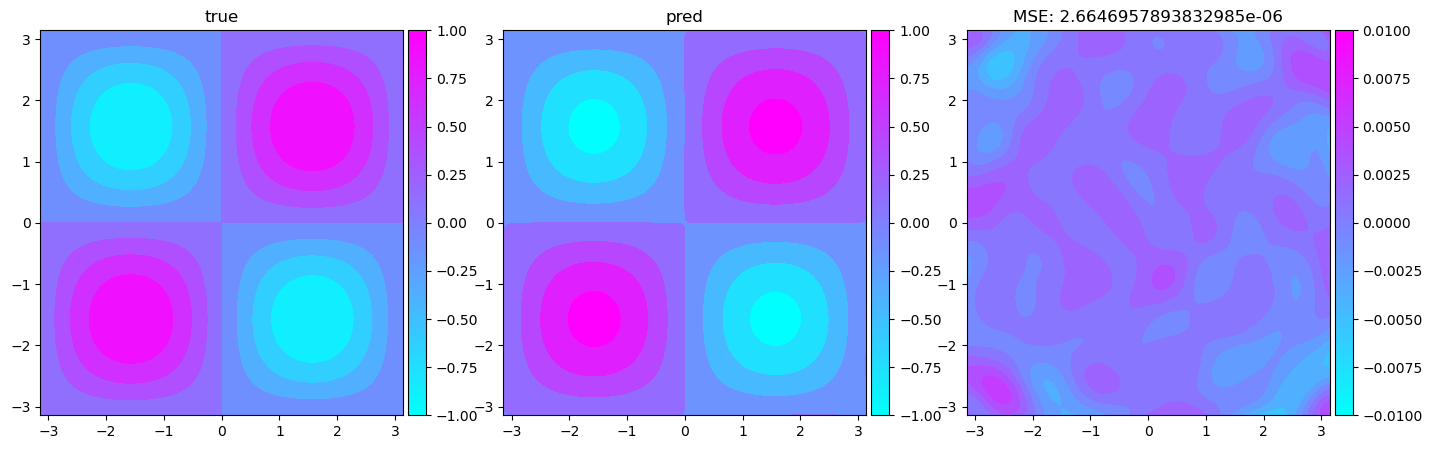

In [8]:
x_test = np.linspace(-np.pi, np.pi, 101)
y_test = np.linspace(-np.pi, np.pi, 101)
xy_test = tensor_grid([x_test, y_test])
u_test = f(xy_test[:, 0:1], xy_test[:, 1:2])
u_pred = model(tf.constant(xy_test, dtype = tf.float32)).numpy()[:, 0:1]

import matplotlib as mpl
from matplotlib.cm import cool
from matplotlib.colors import Normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap = cool
norm = Normalize(vmin=-1.0, vmax=1.0)

X, Y = np.meshgrid(x_test, y_test)
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.subplots_adjust(right = 1.0)

im0 = ax[0].contourf(X, Y, u_test.reshape((len(y_test), len(x_test))), cmap = cmap, norm = norm)
ax[0].set_title("true")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-1.0, vmax=1.0)
im1 = ax[1].contourf(X, Y, u_pred.reshape((len(y_test), len(x_test))), cmap = cmap, norm = norm)
ax[1].set_title("pred")
ax[1].set_xlabel("")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-1e-2, vmax=1e-2)
im2 = ax[2].contourf(X, Y, u_test.reshape((len(y_test), len(x_test)))-u_pred.reshape((len(y_test), len(x_test))), cmap = cmap, norm = norm)
ax[2].set_title("MSE: {}".format(np.mean(np.square(u_test - u_pred))))
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

plt.show()